## This assignment may be worked individually or in pairs. 
## Enter your name/names here:
    

In [1]:
# David Mao, dm46452
# Stephen Aigbomian, sa46979

# Assignment 2: Naive Bayes and KNN classifier

In this assignment you'll implement the Naive Bayes and KNN classifier to classify patients as either having or not having diabetic retinopathy. For this task we'll be using the same Diabetic Retinopathy data set which was used in the previous assignment on decision trees. The implementation details are up to you but, generally it is a good idea to divide your code up into helper functions.

In [2]:
# Standard Headers
# You are welcome to add additional headers if you wish
# EXCEPT for scikit-learn... You may NOT use scikit-learn for this assignment!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt
from random import shuffle
from collections import OrderedDict, defaultdict
import heapq
from functools import reduce
import time

In [3]:
class DataPoint:
    def __str__(self):
        return "< " + str(self.label) + ": " + str(self.features) + " >"
    def __init__(self, label, features):
        self.label = label # the classification label of this data point
        self.features = features

Read the data from a CSV file. You may either put it into a list of `DataPoints` as you did on the previous assignment (class provided above), or you may choose to store it any any format you wish, like a Pandas dataframe, or any other format you'd like.

In [4]:
data_frame = pd.read_csv("messidor_features.txt", header=None)
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


## Part 1: Naive Bayes Classifier

Naive Bayes (NB) classifier is a simple probabilistic classifier that is based on applying the Bayes' theorem and assumes a strong (naive) independence between features. The Diabetic Retinopath data set contains both categorical and continuous features. Dealing with categorical features has been already been discussed in detail in class. Continuous attributes, on the other hand, are more interesting to handle. Most commonly, this is done by assuming normal probability distribution over the feature values or by binning the attribute values in a fixed number of bins. In this assignment you'll be implementing the binning approach. For each continuous attribute, you'll construct 3 equal sized bins. For example, feature 5 ranges from `[1 - 120]` the 3 bins that you'll construct will be `[1 - 40]`, `[41 - 80]`, `[81 - 120]`.

Q1. Implement a Naive Bayes classifier. Measure the accuracy of your classifier using 5-fold cross validation and display the confusion matrix. Also print the precision and recall for class label 1 (patients that have been diagnosed with the disease).

In [5]:
# your code goes here

def calcAccuracy(classifier, data):
    total = 0
    num_correct = 0
    data_array = data.values
    for data_point in data_array:
        if classifier.classify(data_point) == data_point[19]:
            num_correct += 1
        total += 1
    
    return num_correct / total

binary_features = (0, 1, 18, 19)

class Naive_Bayes_Classifier:
    """
    initialized with a set of data, a list of conditional proportions given label == 1 and label == 0
    """
    def __init__(self, data):
        self.data = data
        self.cond_pos = []
        self.cond_neg = []
    
    """
    computes conditional proportions in data set for a feature given that a label
    """
    def compute_conditionals(self, label, feature_index):
        data = self.data[self.data[19] == label]
        if feature_index in binary_features:
            num_pos, num_neg = self.compute_binary_prop(data, feature_index)
            """
            depending on value of label, append to either the list of conditional positive or
            conditional negative proportions
            """
            if label:
                self.cond_pos.append({1: num_pos, 0: num_neg})
            else:
                self.cond_neg.append({1: num_pos, 0: num_neg})
        else:
            """
            same as the above, but for continuous distributions
            """
            props = self.compute_cont_prop(data, feature_index)
            if label:
                self.cond_pos.append(props)
            else:
                self.cond_neg.append(props)
    """
    compute the number of entries with a feature == 1 and total number of entries
    """
    def compute_binary_prop(self, data, feature_index):
        length = len(data[feature_index])
        num_pos = len(data[data[feature_index] == 1])
        return (num_pos, length - num_pos)
    
    """
    bins entries into 3 equal size bins
    """
    def compute_cont_prop(self, data, feature_index):
        feature_min = data[feature_index].min()
        feature_max = data[feature_index].max()
        bin_size = (feature_max - feature_min) / 3
        bins = []
        """
        construct bins
        """
        start = feature_min
        end = feature_min + bin_size
        for i in range(3):
            bins.append((start, end))
            start += bin_size
            end += bin_size
        props = OrderedDict()
        
        """
        put data into bins
        """
        for i in range(3):
            cur_bin = bins[i]
            bin_start, bin_end = cur_bin
            """
            we want the first two bins to be left inclusive, right exclusive
            and the last bin to be inclusive
            """
            if i < 2:
                props[(bin_start, bin_end)] = len(data[(bin_start <= data[feature_index]) & (data[feature_index] < bin_end)])
            else:
                props[(bin_start, bin_end)] = len(data[(bin_start <= data[feature_index]) & (data[feature_index] <= bin_end)])
        return props
    
    def train(self):
        """
        compute conditional proportions for label == 1 and label == 0 for each feature
        """
        for i in range(19):
            self.compute_conditionals(1, i)
            self.compute_conditionals(0, i)
    
    """
    calculate probability of data_point having a classification of label
    """
    def calculate_prob(self, data_point, label):
        props = []
        if label:
            props = self.cond_pos
        else:
            props = self.cond_neg
        
        prob = 1.0
        for feature_index in range(19):
            feature = data_point[feature_index]
            feature_props = props[feature_index]
            if feature_index in binary_features:
                """
                calculate chance of having a feature, given label
                """
                if feature:
                    prob *= feature_props[1] / sum(feature_props.values())
                else:
                    prob *= feature_props[0] / sum(feature_props.values())
            else:
                """
                classify feature in bins
                """
                for index, cur_bin in enumerate(feature_props.keys()):
                    bin_start, bin_end = cur_bin
                    if index < 2:
                        if bin_start <= feature < bin_end:
                            prob *= feature_props[cur_bin] / sum(feature_props.values())
                    else:
                        if bin_start <= feature <= bin_end:
                            prob *= feature_props[cur_bin] / sum(feature_props.values())
        return prob
    
    """
    calculate probability of data_point having label == 1 or label == 0, take greater of the two
    """
    def classify(self, data_point):
        prob_pos = self.calculate_prob(data_point, 1)
        prob_neg = self.calculate_prob(data_point, 0)
        return 1 if prob_pos > prob_neg else 0
    
d = pd.read_csv("messidor_features.txt", header=None)
test_set_len = len(d) // 5
accuracies = []
for i in range(5):
# partition data into train_set and test_set
    train_set = d[0:i * test_set_len].append(d[(i + 1) * test_set_len:len(d)])
    test_set = d[i * test_set_len:(i + 1) * test_set_len]

    print ('Training set size:', len(train_set))
    print ('Test set size    :', len(test_set))

    # create the classifier
    bayes = Naive_Bayes_Classifier(train_set)
    bayes.train()

    # calculate the accuracy of the classifier
    accuracy = calcAccuracy(bayes, test_set)
    accuracies.append(accuracy)
    print ('The accuracy on the test set ', i, ' is ', str(accuracy * 100.0))
avg_accuracy = sum(accuracies) / len(accuracies)
print ('The average accuracy on the data set is: ', str(avg_accuracy))

Training set size: 921
Test set size    : 230
The accuracy on the test set  0  is  61.30434782608696
Training set size: 921
Test set size    : 230
The accuracy on the test set  1  is  58.69565217391305
Training set size: 921
Test set size    : 230
The accuracy on the test set  2  is  58.26086956521739
Training set size: 921
Test set size    : 230
The accuracy on the test set  3  is  57.826086956521735
Training set size: 921
Test set size    : 230
The accuracy on the test set  4  is  51.73913043478261
The average accuracy on the data set is:  0.5756521739130435



## Part 2: K Nearest Neighbor (KNN) Classifier

The KNN classifier consists of two stages:-
- In the training stage, the classifier takes the training data and simply memorizes it
- In the test stage, the classifier compares the test data with the training data and simply returns the maximum occuring label of the k nearest data points.

The distance calculation method is central to the algorithm, typically Euclidean distance is used but other distance metrics like Manhattan distance can also be used. In this assignment you'll be implementing the classifier using the Euclidean distance metric. It is important to note that, Euclidean distance is very sensitive to the scaling of different attributes hence, before you can build your classifier you have to normalize the values of each feature in the data set.

Q2. Normalize the dataset so that each feature value lies between `[0-1]`.

In [6]:
# your code goes here
knn_data = data_frame.copy()

def normalize(val, col_min, col_max):
    return (val - col_min) / (col_max - col_min)

for col_index in knn_data:
    if col_index in binary_features:
        continue
    col_min = knn_data[col_index].min()
    col_max = knn_data[col_index].max()
    knn_data[col_index] = knn_data[col_index].map(lambda x: normalize(x, col_min, col_max))

knn_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,0.140000,0.160305,0.176471,0.173077,0.177083,0.147727,0.122764,0.106359,0.049693,0.012913,0.000362,0.000342,0.000661,0.001271,0.530801,0.261133,1,0
1,1,1,0.153333,0.175573,0.176471,0.163462,0.156250,0.136364,0.142126,0.142403,0.031351,0.003918,0.000076,0.000194,0.000657,0.001264,0.682302,0.536341,0,0
2,1,1,0.406667,0.450382,0.487395,0.509615,0.479167,0.363636,0.137472,0.167497,0.119614,0.081188,0.027106,0.018571,0.007043,0.002509,0.726836,0.437973,0,1
3,1,1,0.360000,0.396947,0.436975,0.471154,0.437500,0.340909,0.099403,0.110368,0.085971,0.051525,0.016340,0.013555,0.001289,0.000496,0.514678,0.352675,0,0
4,1,1,0.286667,0.328244,0.361345,0.384615,0.395833,0.295455,0.043799,0.051281,0.003869,0.000000,0.000000,0.000000,0.000000,0.000000,0.481936,0.407122,0,1


Q3. Build your KNN classifier. 

In [7]:
# your code goes here

def calc_dist(data_1, data_2):
    dist = 0.0
    for i in range(19):
        dist += (data_1[i] - data_2[i]) ** 2
    return sqrt(dist)
    
    
class KNN:
    def __init__(self, data, k):
        self.data = data
        self.k = k
    
    def classify(self, data_point):
        nearest_neighbors = []
        num_pos = 0
        for datum in self.data.values:
            euc_dist = calc_dist(datum, data_point)
            if len(nearest_neighbors) < self.k:
                # heap insertion, use -euc_dist because heapq is min heap
                heapq.heappush(nearest_neighbors, (-euc_dist, datum[19]))
                num_pos += datum[19]
            else:
                # compare euc dist to largest value in heap
                if euc_dist < abs(nearest_neighbors[0][0]):
                    num_pos -= nearest_neighbors[0][1]
                    heapq.heappop(nearest_neighbors)
                    heapq.heappush(nearest_neighbors, (-euc_dist, datum[19]))
                    num_pos += datum[19]
        
        return 1 if num_pos > (self.k // 2) else 0

Q4. Find the best value of k using 5-fold cross validation. In each fold of CV, divide your data into a training set and a validation set. Try k ranging from 1 to 10 and plot the accuracies using 5-fold CV. Use this plot to identify the best value of k (provide reasoning).

In [8]:
def find_best_k(data):
    # your code goes here
    test_set_len = len(data) // 5
    d = defaultdict(list)

    for i in range(5):
    # partition data into train_set and test_set
        train_set = data[0:i * test_set_len].append(data[(i + 1) * test_set_len:len(data)])
        test_set = data[i * test_set_len:(i + 1) * test_set_len]
        for j in range(1, 10, 2):
            knn = KNN(train_set, j)
            acc = calcAccuracy(knn, test_set)
            d[j].append(acc)

    avg_accs = []
    best_k = 1
    best_acc = 0
    for k, accuracies in d.items():
        avg_acc = sum(accuracies) / len(accuracies)
        avg_accs.append((k, avg_acc))
        if avg_acc > best_acc:
            best_k = k
            best_acc = avg_acc

    labels = ['k', 'average accuracy']
    new_data_f = pd.DataFrame(data=avg_accs, columns=labels)
    plot = new_data_f.plot.line(x="k", y="average accuracy")
    return (best_k, plot)

Q5. Now measure the accuracy of your classifier using 5-fold cross validation. In each fold of this CV, divide your data into a training set and a test set. The training set should get sent through your code for Q4, resulting in a value of k to use. Using that k, calculate an accuracy on the test set. You will average the accuracy over all 5 folds to obtain the final accuracy measurement. Print the accuracy as well as the precision and recall for class label 1 (patients that have been diagnosed with the disease).

9-NN fold: 0 accuracy: 0.591304347826087
5-NN fold: 1 accuracy: 0.6260869565217392
7-NN fold: 2 accuracy: 0.6826086956521739
9-NN fold: 3 accuracy: 0.6
1-NN fold: 4 accuracy: 0.5739130434782609
Average accuracy for across 5 folds: 0.6147826086956523


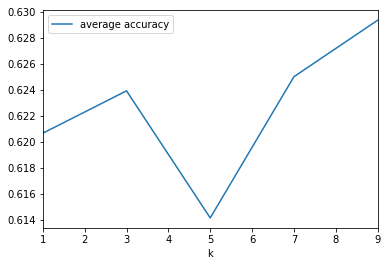

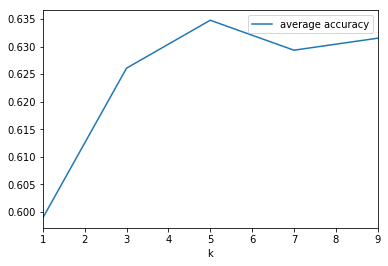

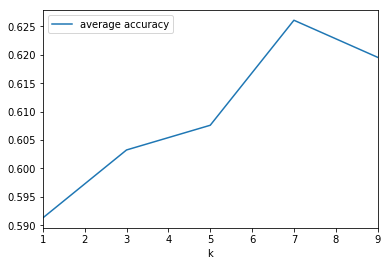

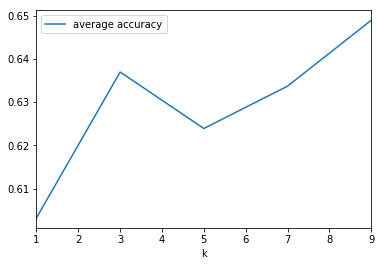

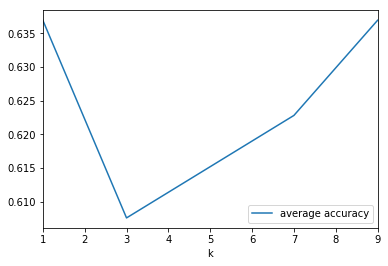

In [9]:
# your code goes here
accs = []
for i in range(5):
# partition data into train_set and test_set
    train_set = knn_data[0:i * test_set_len].append(knn_data[(i + 1) * test_set_len:len(knn_data)])
    test_set = knn_data[i * test_set_len:(i + 1) * test_set_len]
    k, plot = find_best_k(train_set)
    plot.plot()
    knn = KNN(train_set, k)
    acc = calcAccuracy(knn, test_set)
    accs.append(acc)
    print("{}-NN fold: {} accuracy: {}".format(k, i, acc))
avg_acc = sum(accs) / len(accs)
print("Average accuracy for across 5 folds:", avg_acc)


### To explore further:

1) Use scikit-learn's NearestNeighbor classifier to classify the data. Compare those results to your own. The documentation can be found [here](http://scikit-learn.org/stable/modules/neighbors.html), specifically section 1.6.2 and the link to the [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).

2) Use scikit-learn's Naive Bayes classifier to classify the data. Compare those results to your own. The documentation is found [here](http://scikit-learn.org/stable/modules/naive_bayes.html), specifically section 1.9.2 and the link to [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). You will want to bin the continuous attributes, as you did above, and consider each bin to be a categorical value for that attribute. For example, feature 5 ranges from [1 - 120], and the 3 bins that you'll construct will be [1 - 40], [41 - 80], [81 - 120]. You can think of this as saying that feature 5 can take 1 of 3 values: low, med, or high. With binning, you have transformed all of your features into categorical features and the MultinomialNB version of Naive Bayes is what should be used for all categorical data. 